## 参考资料:

* [Node2Vec代码实战 - Alias Sampling复现（同济子豪兄）](https://www.bilibili.com/video/BV1VS4y1E7Me/?spm_id_from=333.788&vd_source=36e948dc2acdb36d7055f879d377b529)

* [Node2Vec官方作者Aditya Grover代码](https://github.com/aditya-grover/node2vec)



## 导入工具包

In [1]:
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import networkx as nx
from gensim.models import Word2Vec
import random

import matplotlib.pyplot as plt
%matplotlib inline

## 读入命令行参数

In [2]:
def parse_args():
    '''
    Parses the node2vec arguments.
    '''
    # 使用parser加载信息
    parser = argparse.ArgumentParser(description="Run node2vec.")
    # 输入文件：邻接表
    parser.add_argument('--input', nargs='?', default='karate.edgelist',
                        help='Input graph path')
    # 输出文件：节点嵌入表
    parser.add_argument('--output', nargs='?', default='karate.emb',
                        help='Embeddings path')
    # embedding嵌入向量维度
    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')
    # 随机游走序列长度
    parser.add_argument('--walk-length', type=int, default=10,
                        help='Length of walk per source. Default is 80.')
    # 每个节点生成随机游走序列次数
    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')
    # word2vec窗口大小，word2vec参数
    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')
    # SGD优化时epoch数量，word2vec参数
    parser.add_argument('--iter', default=1, type=int,
                        help='Number of epochs in SGD')
    # 并行化核数，word2vec参数
    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')
    # 参数p
    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')
    # 参数q
    parser.add_argument('--q', type=float, default=2,
                        help='Inout hyperparameter. Default is 2.')
    # 连接是否带权重
    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)
    
    # 有向图还是无向图
    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)
    
    return parser.parse_args(args=[])

args = parse_args()

In [3]:
args

Namespace(input='karate.edgelist', output='karate.emb', dimensions=128, walk_length=10, num_walks=10, window_size=10, iter=1, workers=8, p=1, q=2, weighted=False, unweighted=True, directed=False, undirected=True)

## 载入图

In [4]:
# 连接带权重
if args.weighted:
    G = nx.read_edgelist(args.input, nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())
# 连接不带权重
else:
    G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = np.abs(np.random.randn())
        
# 无向图
if not args.directed:
    G = G.to_undirected()

In [5]:
len(G)

34

In [6]:
G.nodes

NodeView((1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27))

In [7]:
len(G.edges)

77

In [8]:
G.edges

EdgeView([(1, 32), (1, 22), (1, 20), (1, 18), (1, 14), (1, 13), (1, 12), (1, 11), (1, 9), (1, 8), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (32, 34), (32, 33), (32, 29), (32, 26), (32, 25), (22, 2), (20, 34), (20, 2), (18, 2), (14, 34), (14, 4), (14, 3), (14, 2), (13, 4), (11, 6), (11, 5), (9, 34), (9, 33), (9, 3), (8, 4), (8, 3), (8, 2), (7, 17), (7, 6), (7, 5), (6, 17), (4, 3), (4, 2), (3, 10), (3, 33), (3, 29), (3, 28), (3, 2), (2, 31), (31, 34), (31, 33), (10, 34), (33, 34), (33, 15), (33, 16), (33, 19), (33, 21), (33, 23), (33, 24), (33, 30), (29, 34), (28, 34), (28, 24), (28, 25), (34, 15), (34, 16), (34, 19), (34, 21), (34, 23), (34, 24), (34, 30), (34, 27), (24, 30), (24, 26), (30, 27), (26, 25)])

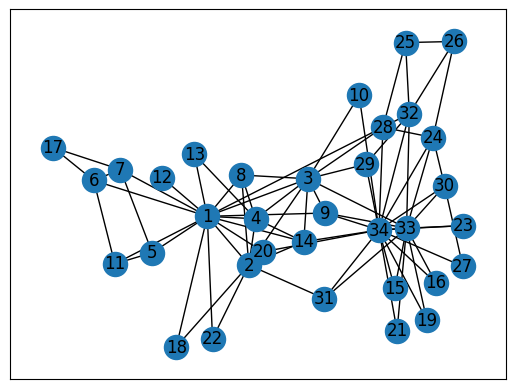

In [9]:
# 可视化
pos = nx.spring_layout(G, seed=4)
nx.draw_networkx(G, pos, with_labels=True)
plt.show()

## Alias Sampling

参考博客

https://keithschwarz.com/darts-dice-coins

https://www.bilibili.com/video/av798804262

https://www.cnblogs.com/Lee-yl/p/12749070.html

![](alias-sampling.png)

In [10]:
def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    # q corrsespond to Prob
    q = np.zeros(K)

    # J Alias
    J = np.zeros(K, dtype=np.int)


    smaller = []
    larger = []
    
    # 将各个概率分成两组，一组的概率值大于1，另一组的概率值小于1
    for kk, prob in enumerate(probs):
        q[kk] = K*prob # 每类事件的概率 乘 事件个数
        
        # 判定”劫富”和“济贫“的对象
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)
    
    # 使用贪心算法，将概率值小于1的不断填满
    # pseudo code step 3
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        # 更新概率值，劫富济贫，削峰填谷
        q[large] = q[large] - (1 - q[small])

        if q[large] < 1.0:
            smaller.append(large) # 把被打倒的土豪归为贫农
        else:
            larger.append(large)
    

    return J, q

In [11]:
def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    O(1)的采样
    '''
    K = len(J) # 事件个数

    kk = int(np.floor(np.random.rand()*K)) # 生成1到K的随机整数
    if np.random.rand() < q[kk]:
        return kk # 取自己本来就对应的事件 
    else:
        return J[kk] # 取alias事件

In [12]:
def get_alias_edge(src, dst):
    p = args.p
    q = args.q

    unnormalized_probs = []
    
    # 论文3.2.2节核心算法，计算各条边的转移权重
    for dst_nbr in sorted(G.neighbors(dst)):
        if dst_nbr == src:
            unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
        elif G.has_edge(dst_nbr, src):
            unnormalized_probs.append(G[dst][dst_nbr]['weight'])
        else:
            unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)

    # 归一化各条边的转移权重
    norm_const = sum(unnormalized_probs)
    normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
    
    # 执行 Alias Sampling
    return alias_setup(normalized_probs)

In [13]:
get_alias_edge(15, 16)

(array([1, 0]), array([0.65471754, 1.        ]))

In [14]:
is_directed = args.directed
alias_nodes = {}

# 节点概率alias sampling和归一化
for node in G.nodes():
    unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
    norm_const = sum(unnormalized_probs)
    normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
    alias_nodes[node] = alias_setup(normalized_probs)
    # 信息展示
    if node == 25:
        print('25号节点')
        print(unnormalized_probs)
        print(norm_const)
        print(normalized_probs)
        print(alias_nodes[node])

25号节点
[0.22021422811530975, 1.8401940601421136, 0.3552982601622395]
2.415706548419663
[0.09115934559989176, 0.7617622518537919, 0.14707840254631627]
(array([1, 0, 1]), array([0.27347804, 1.        , 0.44123521]))


In [15]:
alias_edges = {}
triads = {}

# 边概率alias sampling和归一化
if is_directed:
    for edge in G.edges():
        alias_edges[edge] = get_alias_edge(edge[0], edge[1])
else:
    for edge in G.edges():
        alias_edges[edge] = get_alias_edge(edge[0], edge[1])
        alias_edges[(edge[1], edge[0])] = get_alias_edge(edge[1], edge[0])

In [16]:
# 每个节点的 J表 和 q表 （不考虑p、q值）
alias_nodes

{1: (array([ 0,  0,  1,  2,  1,  3,  2,  3,  5,  5,  9,  9, 10, 10, 10, 13]),
  array([1.        , 0.55688688, 0.68981526, 0.79986941, 0.55215939,
         0.71566902, 0.32672535, 0.3921261 , 0.5898152 , 0.94611159,
         0.88266577, 0.14058341, 0.42821645, 0.84756468, 0.44350713,
         0.06357989])),
 32: (array([2, 3, 0, 2, 3, 3]),
  array([0.08177902, 0.54861266, 1.        , 0.92079355, 0.73178282,
         0.93025478])),
 22: (array([1, 0]), array([0.56400029, 1.        ])),
 20: (array([0, 0, 1]), array([1.        , 0.72221949, 0.35920155])),
 18: (array([1, 0]), array([0.92557241, 1.        ])),
 14: (array([3, 0, 4, 1, 3]),
  array([0.1029531 , 1.        , 0.18380878, 0.95945298, 0.84250552])),
 13: (array([0, 0]), array([1.        , 0.35849305])),
 12: (array([0]), array([1.])),
 11: (array([0, 0, 1]), array([1.        , 0.97680978, 0.48232317])),
 9: (array([1, 0, 3, 1]),
  array([0.48479023, 1.        , 0.49091589, 0.72457177])),
 8: (array([3, 0, 3, 1]),
  array([0.458

In [17]:
# 二阶随机游走（考虑p、q值）
alias_edges

{(1, 32): (array([2, 3, 0, 2, 3, 3]),
  array([0.16135875, 0.5412357 , 1.        , 0.86807235, 0.72194285,
         0.91774605])),
 (32,
  1): (array([ 0,  0,  1,  2,  1,  3,  2,  3,  5,  5,  9,  9, 10, 10, 10, 13]), array([1.        , 0.56259874, 0.70291702, 0.8204516 , 0.54997393,
         0.74450052, 0.32543217, 0.39057406, 0.58748071, 0.98194702,
         0.92666835, 0.14002698, 0.42652156, 0.90358023, 0.44175172,
         0.12665648])),
 (1, 22): (array([1, 0]), array([0.56400029, 1.        ])),
 (22,
  1): (array([ 0,  0,  1,  2,  0,  3,  0,  2,  3,  5,  9,  9, 10, 10, 10, 13]), array([1.        , 0.6320202 , 0.45580046, 0.70669722, 0.49391948,
         0.66549372, 0.29226347, 0.35076596, 0.52760349, 0.61018671,
         0.76438619, 0.12575514, 0.38304962, 0.6526898 , 0.79345499,
         0.0568737 ])),
 (1, 20): (array([0, 0, 1]), array([1.        , 0.64085145, 0.19103761])),
 (20,
  1): (array([ 0,  0,  1,  2,  0,  0,  0,  3,  9,  3,  9, 10, 13, 10, 13, 13]), array([1.        ,

## 生成一条随机游走序列

In [18]:
def node2vec_walk(walk_length, start_node):
    '''
    从指定的起始节点，生成一个随机游走序列
    '''
    # 上一步计算出的alias table，完成O(1)的采样

    walk = [start_node]

    #  直到生成长度为walk_length的节点序列位为止
    while len(walk) < walk_length:
        cur = walk[-1]
        # 对邻居节点排序，目的是和alias table计算时的顺序对应起来
        cur_nbrs = sorted(G.neighbors(cur))
        if len(cur_nbrs) > 0:
            # 节点序列只有一个节点的情况
            if len(walk) == 1:
                walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
            # 节点序列大于一个节点的情况
            else:
                # 看前一个节点,prev是论文中的节点t
                prev = walk[-2]
                next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                    alias_edges[(prev, cur)][1])]
                walk.append(next)
        else:
            break

    return walk

In [19]:
node2vec_walk(7, 3)

[3, 29, 32, 29, 34, 15, 34]

## 采样得到所有随机游走序列

In [20]:
def simulate_walks(num_walks, walk_length):
    '''
    图中每个节点作为起始节点，生成 num_walk 个随机游走序列
    '''
    walks = []
    nodes = list(G.nodes())
    print('Walk iteration:')
    for walk_iter in range(num_walks):
        print(str(walk_iter+1), '/', str(num_walks))
        # 打乱节点顺序
        random.shuffle(nodes)
        for node in nodes:
            walks.append(node2vec_walk(walk_length=walk_length, start_node=node))

    return walks

In [21]:
# 测试
simulate_walks(3, 7)

Walk iteration:
1 / 3
2 / 3
3 / 3


[[32, 29, 34, 31, 34, 15, 34],
 [4, 3, 28, 25, 28, 3, 4],
 [18, 2, 20, 1, 12, 1, 12],
 [22, 2, 4, 14, 2, 4, 2],
 [29, 3, 1, 2, 22, 2, 31],
 [6, 1, 18, 2, 4, 1, 22],
 [21, 34, 29, 34, 29, 34, 19],
 [24, 30, 33, 34, 32, 25, 28],
 [31, 34, 9, 34, 21, 33, 19],
 [11, 5, 1, 22, 2, 18, 2],
 [3, 4, 1, 13, 1, 5, 1],
 [17, 7, 17, 6, 7, 6, 1],
 [28, 24, 28, 3, 9, 3, 29],
 [26, 32, 26, 25, 28, 25, 28],
 [19, 33, 34, 14, 34, 24, 33],
 [2, 4, 14, 4, 14, 34, 9],
 [8, 2, 14, 4, 2, 4, 14],
 [30, 27, 30, 24, 30, 33, 16],
 [7, 17, 7, 6, 17, 6, 17],
 [15, 34, 29, 32, 29, 34, 28],
 [27, 34, 14, 34, 33, 32, 29],
 [23, 34, 10, 34, 30, 24, 30],
 [34, 14, 2, 1, 2, 22, 2],
 [1, 7, 1, 5, 11, 1, 6],
 [10, 34, 15, 34, 32, 29, 32],
 [20, 2, 31, 2, 3, 1, 12],
 [25, 28, 25, 32, 33, 34, 15],
 [33, 23, 33, 21, 33, 21, 34],
 [14, 4, 3, 4, 2, 3, 1],
 [9, 1, 5, 1, 4, 1, 2],
 [12, 1, 5, 1, 5, 1, 13],
 [16, 33, 31, 34, 28, 3, 28],
 [5, 11, 5, 1, 2, 4, 2],
 [13, 1, 2, 14, 34, 14, 4],
 [29, 32, 29, 34, 29, 32, 26],
 [19, 34, 

In [22]:
args.num_walks

10

In [23]:
args.walk_length

10

In [24]:
# 生成训练用的随机游走序列
walks = simulate_walks(args.num_walks, args.walk_length)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [25]:
len(walks)

340

In [26]:
walks[0]

[20, 2, 20, 2, 4, 8, 4, 2, 4, 2]

In [27]:
# 将node的类型int转化为string
walk_str = []
for walk in walks:
    tmp = []
    for node in walk:
        tmp.append(str(node))
    walk_str.append(tmp)

In [28]:
len(walk_str)

340

In [29]:
walk_str[1]

['6', '1', '3', '1', '18', '2', '4', '2', '14', '4']

## 利用word2vec训练Node2Vec模型

In [30]:
# 调用 gensim 包运行 word2vec
model = Word2Vec(walk_str, vector_size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers)


In [31]:
# 导出embedding文件
model.wv.save_word2vec_format(args.output)

## 结果分析和可视化

### 查看 Node Embedding

In [32]:
model.wv.get_vector('17').shape

(128,)

In [33]:
model.wv.get_vector('17')

array([ 0.05030569, -0.01148644,  0.11276381, -0.02450852,  0.00803201,
       -0.08742246,  0.01551476,  0.03727151,  0.00627559,  0.02345394,
        0.10813974, -0.05773929, -0.02897483, -0.03555898,  0.01979391,
       -0.04900616,  0.01735621,  0.02649279, -0.06749365,  0.03826749,
        0.06779111,  0.05304061,  0.04027285,  0.03793898, -0.11634336,
        0.07957909, -0.05818281,  0.05024271,  0.0274208 , -0.03863368,
       -0.15417987,  0.03195244, -0.04108687,  0.00039549, -0.03193031,
        0.018914  ,  0.11456054,  0.0358413 ,  0.11251912, -0.01539381,
       -0.02965643,  0.08496363, -0.04425171, -0.03703002,  0.04364294,
        0.00141756,  0.02645585, -0.06437148, -0.0255911 ,  0.05012865,
        0.04550511,  0.02426345,  0.10712382,  0.03214685,  0.05704545,
        0.03246491,  0.091486  ,  0.01289231, -0.05245761,  0.00540475,
        0.04598118, -0.06382298,  0.03382241,  0.04078436,  0.07766222,
       -0.05256613,  0.03526942,  0.02363946, -0.00687125, -0.05

### 查找相似节点

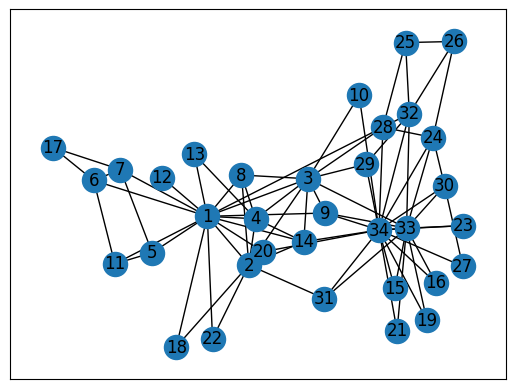

In [34]:
pos = nx.spring_layout(G, seed=4)
nx.draw_networkx(G, pos, with_labels=True)
plt.show()

In [35]:
# 节点对 相似度
print(model.wv.similarity('25', '26'))
print(model.wv.similarity('17', '25'))

0.99361795
0.9934363


In [36]:
# 找到最相似的节点
print(model.wv.most_similar('25'))

[('1', 0.9964584708213806), ('34', 0.9955700039863586), ('24', 0.9955406785011292), ('33', 0.9953609704971313), ('3', 0.9952919483184814), ('4', 0.9950805902481079), ('32', 0.9950778484344482), ('5', 0.9950242638587952), ('2', 0.9949817061424255), ('28', 0.9948425889015198)]


In [37]:
# 自定义相似性距离度量指标
from scipy import spatial
def cos_similarity(v1, v2):
    # 余弦相似度
    return 1 - spatial.distance.cosine(v1, v2)

In [38]:
v1 = model.wv.get_vector('25')
v2 = model.wv.get_vector('26')

In [39]:
cos_similarity(v1, v2)

0.9936178922653198

### Node Embedding聚类

#### 运行聚类

In [40]:
# # DBSCAN聚类
# from sklearn.cluster import DBSCAN
# cluster_labels = DBSCAN(eps=0.5, min_samples=6).fit(X).labels_
# print(cluster_labels)

# KMeans聚类
from sklearn.cluster import KMeans
import numpy as np

X = model.wv.vectors
cluster_labels = KMeans(n_clusters=3, random_state=9).fit(X).labels_

In [41]:
cluster_labels

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### 将networkx中的节点和词向量中的节点对应

In [42]:
colors = []
nodes = list(G.nodes)
for node in nodes: # 按 networkx 的顺序遍历每个节点
    idx = model.wv.key_to_index[str(node)] # 获取这个节点在 embedding 中的索引号
    colors.append(cluster_labels[idx]) # 获取这个节点的聚类结果

In [43]:
colors

[0,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1]

#### 可视化聚类效果

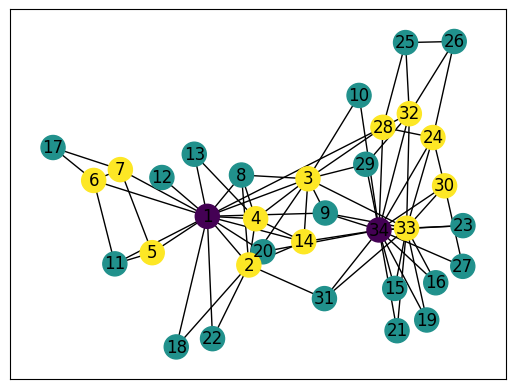

In [47]:
pos = nx.spring_layout(G, seed=4)
nx.draw_networkx(G, pos, node_color=colors, with_labels=True)
plt.show()